# Most of the code in here was provided by Hugging Face Docs

For reference visist: https://huggingface.co/transformers/v3.2.0/custom_datasets.html#tok-ner

# Import Libraries

In [30]:
from pathlib import Path
import re
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, AutoConfig

# Handling Data Set CONLL FILE

In [59]:
# Based on Huggingface Documentation, accomodated for my file
def read_conll(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            if line.strip() == "":  # Skip empty lines
                continue
            parts = line.split()
            if len(parts) >= 3:  # Ensure there are enough parts
                token = parts[0]  # First part is the token
                tag = parts[-1]  # Last part is the tag
                if tag.startswith("B-") or tag.startswith("I-") or tag == "O":  # Filter valid tags
                    tokens.append(token)
                    tags.append(tag)
        if tokens and tags:  # Ensure non-empty before appending
            token_docs.append(tokens)
            tag_docs.append(tags)

    return token_docs, tag_docs

In [78]:
texts, tags = read_conll('../Datasets/project_9.conll')

## Splitting Dataset between Train and Validation

In [79]:
train_texts, val_texts, train_tags, val_tags = train_test_split(texts, tags, test_size=.2)

## Visualizing Tags Frequency

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'O'),
  Text(1, 0, 'I-ALLOCATION'),
  Text(2, 0, 'B-ALLOCATION'),
  Text(3, 0, 'I-BUDGET'),
  Text(4, 0, 'B-LOC'),
  Text(5, 0, 'B-BUDGET'),
  Text(6, 0, 'B-ORG'),
  Text(7, 0, 'I-LOC'),
  Text(8, 0, 'I-ORG'),
  Text(9, 0, 'B-YEAR')])

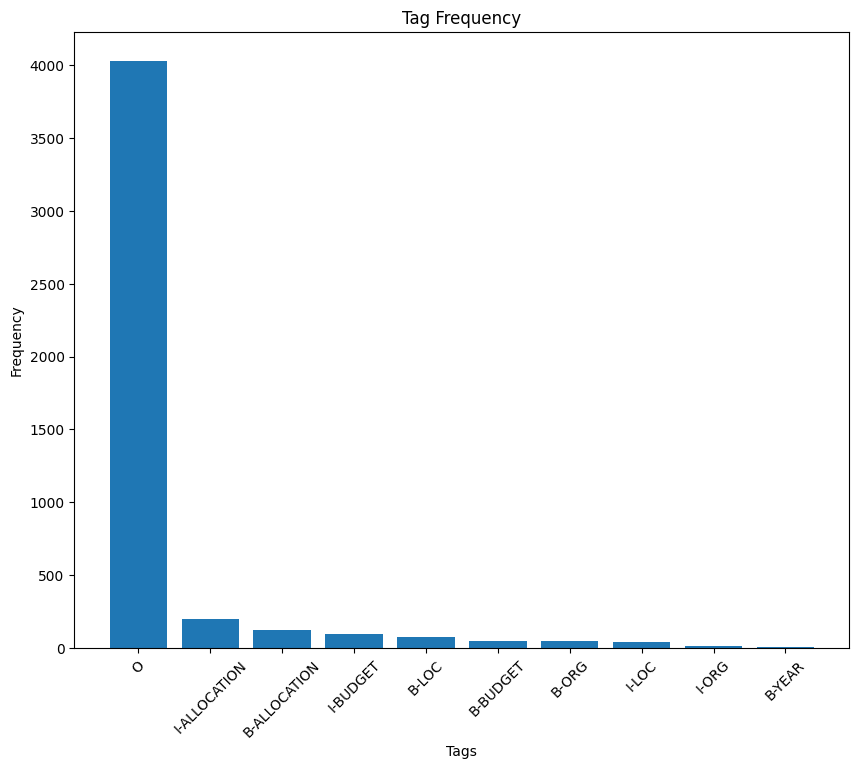

In [80]:
counts = []
# plot train_tags as bars
for list in train_tags:
    tags_counter = Counter(list)
    counts.append(tags_counter)
    
combined_counter = sum(counts, Counter())

items = combined_counter.most_common()

# Unzipping the items into labels and values
labels, values = zip(*items)

plt.figure(figsize=(10, 8))
plt.bar(labels, values)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Tag Frequency')
plt.xticks(rotation=45)  # Rotate labels to make them readable

# Display the plot

## Mapping Tags with IDs

In [63]:
# from Huggingface docs 
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

## Config Variable

In this step we are creating the config variable that will tell the model the TAG2ID and ID2TAG dictionaries.

In [64]:
config = AutoConfig.from_pretrained('FacebookAI/xlm-roberta-large-finetuned-conll03-german', 
                                    num_labels=len(unique_tags), 
                                    id2label=id2tag,
                                    label2id=tag2id)

# Tokenizer & Preparing Encodings for preparing the data for training the Model

In [65]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-large-finetuned-conll03-german')
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

In [66]:
# from Huggingface docs 
def encode_tags(tags, encodings):
    encoded_labels = []
    for doc_labels, doc_offset in zip(tags, encodings.offset_mapping):

        # Create an array to hold the labels for each token in the tokenized input
        doc_enc_labels = np.ones(len(doc_offset), dtype=int) * -100
        
        # Track the current position in the original labels list
        label_idx = 0
        for idx, offset in enumerate(doc_offset):
            # Check if this token is the start of a new original token
            if offset[0] == 0 and label_idx < len(doc_labels):
                # Assign the label of the original token to the first subtoken
                doc_enc_labels[idx] = tag2id[doc_labels[label_idx]]
                label_idx += 1        
        encoded_labels.append(doc_enc_labels.tolist())
    
    return encoded_labels

In [67]:
train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)

# Class CUSTOM Named Entity Recognition Dataset (NER Dataset)

In [68]:
class custom_NER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [69]:
# we don't want to pass this to the model
train_encodings.pop("offset_mapping") 
val_encodings.pop("offset_mapping")

train_dataset = custom_NER(train_encodings, train_labels)
val_dataset = custom_NER(val_encodings, val_labels)

# Load the Model

In [70]:
model = AutoModelForTokenClassification.from_pretrained('FacebookAI/xlm-roberta-large-finetuned-conll03-german',
                                                        config=config, ignore_mismatched_sizes=True)

Some weights of the model checkpoint at FacebookAI/xlm-roberta-large-finetuned-conll03-german were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large-finetuned-conll03-german and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 1024]) in the check

# Train the Model
Model: **FacebookAI/xlm-roberta-large-finetuned-conll03-german**

This Code comes from Hugginface Documentation for training (Fine-Tuning) an LLM

In [71]:
# from Huggingface docs 

training_args = TrainingArguments(
    output_dir='../Models/bftm',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='../Models/bftm/logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                    
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

                                     
100%|██████████| 3/3 [05:29<00:00, 109.67s/it]

{'train_runtime': 329.1329, 'train_samples_per_second': 0.109, 'train_steps_per_second': 0.009, 'train_loss': 1.75132163036981e+35, 'epoch': 3.0}


TrainOutput(global_step=3, training_loss=1.75132163036981e+35, metrics={'train_runtime': 329.1329, 'train_samples_per_second': 0.109, 'train_steps_per_second': 0.009, 'train_loss': 1.75132163036981e+35, 'epoch': 3.0})

# SAVING THE MODEL

In [74]:
model.save_pretrained('../Models/bftm')
tokenizer.save_pretrained('../Models/bftm')

('../Models/bftmdoel_N/tokenizer_config.json',
 '../Models/bftmdoel_N/special_tokens_map.json',
 '../Models/bftmdoel_N/sentencepiece.bpe.model',
 '../Models/bftmdoel_N/added_tokens.json',
 '../Models/bftmdoel_N/tokenizer.json')